In [1]:
%install-location $cwd/swift-install
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path
%install '.package(url: "https://github.com/saeta/Just", from: "0.7.2")' Just
%install '.package(url: "https://github.com/latenitesoft/NotebookExport", from: "0.5.0")' NotebookExport

Installing packages:
	.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")
		Path
	.package(url: "https://github.com/saeta/Just", from: "0.7.2")
		Just
	.package(url: "https://github.com/latenitesoft/NotebookExport", from: "0.5.0")
		NotebookExport
With SwiftPM flags: []
Working in: /tmp/tmpq7sh_vsp/swift-install
/home/alex/swift/tensorflow/usr/bin/swift: /home/alex/miniconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/alex/swift/tensorflow/usr/bin/swift)
/home/alex/swift/tensorflow/usr/bin/swift: /home/alex/miniconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/alex/swift/tensorflow/usr/bin/swift)
/home/alex/swift/tensorflow/usr/bin/swift: /home/alex/miniconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/alex/swift/tensorflow/usr/bin/swift)
/home/alex/swift/tensorflow/usr/bin/swift: /home/alex/miniconda3/envs/swift-env/lib/libuuid.so.1: no version 

In [2]:
//export
import Path
import TensorFlow

### Rando Stuff I need

In [3]:
//export
protocol ConvertibleFromByte: TensorFlowScalar {
    init(_ d:UInt8)
}
extension Float : ConvertibleFromByte {}
extension Int32 : ConvertibleFromByte {}

//export 
import Dispatch

public func getTimeUnit(_ nanoSeconds: Double) -> String {
    let powerOfTen = floor(log10(nanoSeconds))
    switch powerOfTen {
        case 1..<3:
            return "\(nanoSeconds) ns"
        case 3..<6:
            return "\(nanoSeconds/1e3) µs"
        case 6..<9: 
            return "\(nanoSeconds/1e6) ms"
        default: 
            return "\(nanoSeconds/1e9) s"
    }
}

// ⏰Time how long it takes to run the specified function, optionally taking
// the average across a number of repetitions.
public func withTime<T>(_ f: () -> T) -> T {
    let start = DispatchTime.now()
    let value = f()
    let end = DispatchTime.now()
    let nanoSeconds = Double(end.uptimeNanoseconds - start.uptimeNanoseconds)
    print("elapsed time: \(getTimeUnit(nanoSeconds))")
    return value
}

public func timeTrials(trials: Int = 1, _ f: () -> ()) {
    guard trials > 0 else { return }
    
    // Warmup
    if trials > 1 { f() }
    
    var times = [Double]()
    for _ in 1...trials {
        let start = DispatchTime.now()
        f()
        let end = DispatchTime.now()
        let nanoseconds = Double(end.uptimeNanoseconds - start.uptimeNanoseconds)
        times.append(nanoseconds)
    }
    print("average: \(getTimeUnit(times.reduce(0.0, +)/Double(times.count))),   " +
          "min: \(getTimeUnit(times.reduce(times[0], min))),   " +
          "max: \(getTimeUnit(times.reduce(times[0], max)))")
}

public extension String {
    func findFirst(pat: String) -> Range<String.Index>? {
        return range(of: pat, options: .regularExpression)
    }
    func hasMatch(pat: String) -> Bool {
        return findFirst(pat:pat) != nil
    }
}
public func normalizeTensor<T:TensorFlowFloatingPoint>(tensor: Tensor<T>)-> Tensor<T>{
    return (tensor - tensor.mean())/tensor.standardDeviation()
}
public struct AssertionError: Error {
    let message: String
    init(_ message: String){
        self.message = message
    }
}
public func assert(toAssert: Bool, message: String = "Not True!") throws {
    if(!toAssert){
        throw AssertionError(message)
    }
}
public extension StringTensor {
    // Read a file into a Tensor.
    init(readFile filename: String) {
        self.init(readFile: StringTensor(filename))
    }
    init(readFile filename: StringTensor) {
        self = Raw.readFile(filename: filename)
    }

    // Decode a StringTensor holding a JPEG file into a Tensor<UInt8>.
    func decodeJpeg(channels: Int = 0) -> Tensor<UInt8> {
        return Raw.decodeJpeg(contents: self, channels: Int64(channels), dctMethod: "") 
    }
}
public func reLU<T>(tensor: Tensor<T>) -> Tensor<T> where T : FloatingPoint, T: TensorFlowScalar {
    return max(tensor, 0)
}
public func linearCombination<T>(inputs: Tensor<T>, weights: Tensor<T>, bias: Tensor<T>) -> Tensor<T> where T: FloatingPoint, T: TensorFlowScalar {
    return matmul(inputs, weights) + bias
}
public typealias TensorFloat=Tensor<Float>
public func assertNearZero(_ tensor: TensorFloat, _ threshold: Float = 1e-3){
    assert(tensor < threshold, "Expected \(tensor) to be less than \(threshold)")
}
public func assertEquals(_ a: TensorFloat, _ b: TensorFloat, _ message: String) {
    // Check shapes match so broadcasting doesn't hide shape errors.
    assert(a.shape == b.shape)
    assertNearZero(a-b)
}

### Things Needed
----
- Layer Activations Statistics (mean/standard deviation)
- Optimization
- Learning Rate over Time

In [4]:
Array(1...10).enumerated().reversed().forEach {
    print($0, $1)
}

9 10
8 9
7 8
6 7
5 6
4 5
3 4
2 3
1 2
0 1


In [5]:
var yeetBoi = [1,2,3,4,5]
yeetBoi.insert(0, at:0)
yeetBoi

▿ 6 elements
  - 0 : 0
  - 1 : 1
  - 2 : 2
  - 3 : 3
  - 4 : 4
  - 5 : 5


In [6]:
protocol Fam {
    func fam()
}

extension Fam {
    func fam() {
        print("Fam")
    }
}

protocol Ravioli {
    func ravioli()
}

extension Ravioli {
    func ravioli() {
        print("Ravioli")
    }
}

struct FamRavioli: Fam, Ravioli {}

let famRav = FamRavioli()

famRav.fam()
famRav.ravioli()

Fam
Ravioli


In [7]:
var thingDictionary: [Int: [Float]] =  [:]

In [8]:
for a in 1...10 {
    if thingDictionary[a] == nil {
        thingDictionary[a] = [Float(69)]
    } 
    
    thingDictionary[a]?.append(Float(a))
}
thingDictionary

▿ 10 elements
  ▿ 0 : 2 elements
    - key : 6
    ▿ value : 2 elements
      - 0 : 69.0
      - 1 : 6.0
  ▿ 1 : 2 elements
    - key : 5
    ▿ value : 2 elements
      - 0 : 69.0
      - 1 : 5.0
  ▿ 2 : 2 elements
    - key : 3
    ▿ value : 2 elements
      - 0 : 69.0
      - 1 : 3.0
  ▿ 3 : 2 elements
    - key : 9
    ▿ value : 2 elements
      - 0 : 69.0
      - 1 : 9.0
  ▿ 4 : 2 elements
    - key : 7
    ▿ value : 2 elements
      - 0 : 69.0
      - 1 : 7.0
  ▿ 5 : 2 elements
    - key : 10
    ▿ value : 2 elements
      - 0 : 69.0
      - 1 : 10.0
  ▿ 6 : 2 elements
    - key : 8
    ▿ value : 2 elements
      - 0 : 69.0
      - 1 : 8.0
  ▿ 7 : 2 elements
    - key : 2
    ▿ value : 2 elements
      - 0 : 69.0
      - 1 : 2.0
  ▿ 8 : 2 elements
    - key : 1
    ▿ value : 2 elements
      - 0 : 69.0
      - 1 : 1.0
  ▿ 9 : 2 elements
    - key : 4
    ▿ value : 2 elements
      - 0 : 69.0
      - 1 : 4.0


## Model


In [9]:
//export
public struct HyperParameters {
    public let learningRate: Float
}

In [10]:
//export
public protocol ParameterActivationSubscriber {
    func observe(parameterNumber: Int, activations: TensorFloat)
}

In [11]:
//export
public protocol TeachableModel {
    
    func apply(inputTensor: TensorFloat) -> TensorFloat
    
    func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, TeachableModel)
    
    func backwardsPass(ddx: TensorFloat, hyperParameters: HyperParameters) -> TeachableModel    
    
    func addActivationSubscriber(subscriber: @escaping (Int, TensorFloat) -> ()) -> TeachableModel
}

In [12]:
//export
public protocol ModelParameterV2 {
    
    func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, ModelParameterV2)
    
    func apply(_ inputTensor: TensorFloat) -> TensorFloat 
    
    func backwardPass(ddx: TensorFloat, hyperParameters: HyperParameters) -> (TensorFloat, ModelParameterV2)
}

In [13]:
//export
public protocol ModelParameters {
    
    func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, ModelParameters)
    
    func apply(_ inputTensor: TensorFloat) -> TensorFloat 
    
    func backwardPass(ddx: TensorFloat, hyperParameters: HyperParameters) -> (TensorFloat, ModelParameters)
    
    func subscribeToActivations(subscriber:@escaping (Int, TensorFloat) -> ()) -> ModelParameters
}

In [14]:
//export
public struct SequentialParameter: ModelParameters {
    
    private let parameters: [ModelParameterV2]
    private let subscribers: [(Int, TensorFloat) -> ()]
    
    public init(parameters: [ModelParameterV2]) {
        self.parameters = parameters
        subscribers = []
    }
    
    private init(parameters: [ModelParameterV2],
                 subscribers: [(Int, TensorFloat) -> ()]) {
        self.parameters = parameters
        self.subscribers = subscribers
    }
    
    
    public func apply(_ inputTensor: TensorFloat) -> TensorFloat {
        return parameters.reduce(inputTensor) {
            (layerInput, nextParameter) in nextParameter.apply(layerInput)
        }
    }
    
    public func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, ModelParameters) {
        return runThroughLayers({self.parameters}, inputTensor, {
            $0.append($1)
            return $0
        }) { (previousActivations: TensorFloat, 
              parameter: ModelParameterV2, 
              index: Int) -> (TensorFloat, ModelParameterV2) in
            let activations = parameter.forwardPass(inputTensor: previousActivations)
            self.subscribers.forEach { subscriber in
                                      subscriber(index, activations.0)
            }
            return activations
        }
    }
    
    public func backwardPass(ddx: TensorFloat, 
                             hyperParameters: HyperParameters) -> (TensorFloat, ModelParameters) {
        return runThroughLayers({self.parameters.reversed()}, ddx, {
            $0.insert($1, at: 0)
            return $0
        }) { (previousActivations: TensorFloat, 
              parameter: ModelParameterV2, 
              index: Int) -> (TensorFloat, ModelParameterV2) in
            let activations = parameter.backwardPass(ddx: previousActivations,
                                                     hyperParameters: hyperParameters)
            
            return activations
        }
    }
    
    
    private func runThroughLayers(
        _ parameterSupplier: () -> [ModelParameterV2],
        _ initialValue: TensorFloat,
        _ paramAccumulator: (inout [ModelParameterV2], ModelParameterV2) -> [ModelParameterV2],
        _ paramActivator: (TensorFloat, ModelParameterV2, Int) -> (TensorFloat, ModelParameterV2)) 
                                                                            -> (TensorFloat, ModelParameters){
        var nextParamters : [ModelParameterV2] = []
        let (output, forwardParams) = parameterSupplier().enumerated().reduce(
            (activations: initialValue, params:  nextParamters)) {
            (accum, nextParameterAndValue) in 
            let (index, nextParameter) = nextParameterAndValue
            var (activations, params) = accum
            let (nextInput, modifiedParam) = paramActivator(activations, nextParameter, index)
            return (activations: nextInput,
                    params: paramAccumulator(&params, modifiedParam))
        }

        return (output, SequentialParameter(parameters: forwardParams,
                                            subscribers: subscribers))
    }
    
    public func subscribeToActivations(subscriber: @escaping (Int, TensorFloat) -> ()) -> ModelParameters {
        let subscribers: [(Int, TensorFloat) -> ()] = [subscriber] + self.subscribers
        return SequentialParameter(parameters: parameters, 
                                   subscribers: subscribers)
        
    }
    
}

In [15]:
public func reLUAndGradient(inputTensor: TensorFloat) -> (value: TensorFloat, 
                                                   gradientChain: (TensorFloat) -> TensorFloat){
    return (value: max(0.0, inputTensor), 
            gradientChain: {ddx in ddx.replacing(with: TensorFloat(zeros: ddx.shape), where: inputTensor .< 0.0 )})
}

In [16]:
//export
public struct ReLUParameter: ModelParameterV2 {
    
    private let gradientChain: (TensorFloat) -> TensorFloat
    
    public init() {
        gradientChain = { $0 }
    }
    
    private init(_ gradChain: @escaping (TensorFloat) -> TensorFloat) {
        gradientChain = gradChain
    }
    
    public func apply(_ inputTensor: TensorFloat) -> TensorFloat {
        return reLU(tensor: inputTensor)
    }
    
    public func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, ModelParameterV2) {
        let (value, gradientDude) = reLUAndGradient(inputTensor: inputTensor)
        return (value, ReLUParameter(gradientDude))
    }
    
    public func backwardPass(ddx: TensorFloat,
                             hyperParameters: HyperParameters) -> (TensorFloat, ModelParameterV2) {
        let reluDDX = gradientChain(ddx)
        return (reluDDX, self)
    }
}

In [17]:
//export

// Matrix Shapez
// M x N * N x O = M x O

// ddx shape = M x O

public func linearCombinationAndGradient(inputTensor: TensorFloat, 
                                  weightParameter: TensorFloat,
                                  biasParameter: TensorFloat) -> (value: TensorFloat, 
                                                                  gradientChain: (TensorFloat) -> (TensorFloat, TensorFloat, TensorFloat)) {
    return (value: matmul(inputTensor, weightParameter) + biasParameter, 
            gradientChain: { ddx in 
                           ( inputTensor,
                             matmul(inputTensor.transposed(),  ddx),
                             ddx.unbroadcasted(to: biasParameter.shape)
                           )
                           })
}

In [18]:
//export
public extension Tensor where Scalar: TensorFlowFloatingPoint {
    init(kaimingUniform shape: TensorShape, negativeSlope: Double = 1.0) {
        // Assumes Leaky ReLU nonlinearity
        let gain = Scalar.init(TensorFlow.sqrt(2.0 / (1.0 + TensorFlow.pow(negativeSlope, 2))))
        let spatialDimCount = shape.count - 2
        let receptiveField = shape[0..<spatialDimCount].contiguousSize
        let fanIn = shape[shape.count - 2] * receptiveField
        let bound = TensorFlow.sqrt(Scalar(3.0)) * gain / TensorFlow.sqrt(Scalar(fanIn))
        self = bound * (2 * Tensor(randomUniform: shape) - 1) // todo: I goofed with this
    }
}

In [19]:
//export
typealias ThreeInputGradient = (TensorFloat) -> (TensorFloat, TensorFloat, TensorFloat)
public struct DenseLayerV2: ModelParameterV2 {
    let weightParameter: TensorFloat
    let biasParameter: TensorFloat
    private let gradientChain: ThreeInputGradient

    private init(weightParameter: TensorFloat,
                 biasParameter: TensorFloat,
                 gradientChain: @escaping ThreeInputGradient) {        
        self.weightParameter = weightParameter
        self.biasParameter = biasParameter
        self.gradientChain = gradientChain
    }

    private init(denseLayer: DenseLayerV2,
                 gradientChain: @escaping ThreeInputGradient) {
        self.weightParameter = denseLayer.weightParameter
        self.biasParameter = denseLayer.biasParameter
        self.gradientChain = gradientChain
    }

    public init(inputSize: Int,
                outputSize: Int){
        self.weightParameter = TensorFloat(kaimingUniform: TensorShape([inputSize, outputSize]))
        self.biasParameter = TensorFloat(zeros: [outputSize])
        self.gradientChain = { (x: TensorFloat)  in (TensorFloat([1]), TensorFloat([1]), TensorFloat([1]))}
    }

    public func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, ModelParameterV2) {
        let (parameterOutput, parameterGradientChain) =
          linearCombinationAndGradient(inputTensor: inputTensor,
                                       weightParameter: self.weightParameter,
                                       biasParameter: self.biasParameter)

        return (parameterOutput, DenseLayerV2(denseLayer: self,
                                       gradientChain: {ddx in parameterGradientChain(ddx)}))
    }

    public func apply(_ inputTensor: TensorFloat) -> TensorFloat {
        return linearCombination(inputs: inputTensor,
                                       weights: self.weightParameter,
                                       bias: self.biasParameter)
    }

    public func backwardPass(ddx: TensorFloat, 
                             hyperParameters: HyperParameters) -> (TensorFloat, ModelParameterV2) {
        let (ddxInput, ddxParameter, ddxBias) = self.gradientChain(ddx)
        return (ddxInput, DenseLayerV2(
            weightParameter: self.weightParameter - hyperParameters.learningRate * ddxParameter,
            biasParameter: self.biasParameter - hyperParameters.learningRate * ddxBias,
            gradientChain: self.gradientChain))
    }
}



### SequentialModel

In [20]:
struct SequentialModel : TeachableModel {
    
    private let sequentialParameter: ModelParameters
    
    private init(sequentialParameter: ModelParameters){
        self.sequentialParameter = sequentialParameter
    }
    
    public init(layerSizes: [Int]) {
        let denseLayers = layerSizes.prefix(upTo: layerSizes.count - 1)
                                        .enumerated()
                                        .flatMap { 
                                            (element: (Int, Int)) -> [ModelParameterV2] in                                       
                                            if(element.0 < layerSizes.count - 2){
                                               return [DenseLayerV2(inputSize: element.1, 
                                                               outputSize: layerSizes[element.0 + 1]), 
                                                ReLUParameter()]
                                            }
                                            else {
                                                return [
                                                    DenseLayerV2(inputSize: element.1, 
                                                               outputSize: layerSizes[element.0 + 1])
                                                ]
                                            }
                                        }
        self.sequentialParameter = SequentialParameter(parameters: denseLayers)
    }
    
    public func apply(inputTensor: TensorFloat) -> TensorFloat {
        return self.sequentialParameter.apply(inputTensor)
    }
    
    public func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, TeachableModel) {
        let (activations, newSequentialModel) = self.sequentialParameter
                                                        .forwardPass(inputTensor: inputTensor)
        return (activations, SequentialModel(sequentialParameter: newSequentialModel))
    }
    
    public func backwardsPass(ddx: TensorFloat, 
                              hyperParameters: HyperParameters) -> TeachableModel {
        let (_, optimizedSequentialLayer) = self.sequentialParameter.backwardPass(ddx: ddx, 
                                                          hyperParameters: hyperParameters)
        return SequentialModel(sequentialParameter: optimizedSequentialLayer)
    }
    
    public func addActivationSubscriber(subscriber: @escaping (Int, TensorFloat) -> ()) -> TeachableModel {
     return SequentialModel(sequentialParameter: sequentialParameter
                                                       .subscribeToActivations(subscriber: subscriber))   
    }
}

In [21]:
let testSequentialModel = SequentialModel(layerSizes: [8, 6, 3, 1])
testSequentialModel

▿ SequentialModel
  ▿ sequentialParameter : SequentialParameter
    ▿ parameters : 5 elements
      ▿ 0 : DenseLayerV2
        - weightParameter : [[    0.531742,  -0.16041973,  -0.22659162,    0.4891437,  -0.13396582, -0.087965146],
 [ -0.48672417,     -0.50981,  -0.30415565,   0.48503232,  -0.54052085,  0.055182382],
 [ -0.37795827,    0.6086668,   0.44635797,   0.22115964,   0.44927347,    0.4935367],
 [  0.54640234,  -0.60888433,  -0.39720672,   0.46841404,   -0.5780957,  -0.15136695],
 [  0.20016602,   0.34465894,  0.056583554,   -0.3094701,   0.30766055,   0.28652516],
 [ 0.042751566,  -0.20981859,   0.22163516,  -0.50377005,   0.02134432,   0.32411093],
 [ -0.19172424,  -0.49839723,    0.5237634,   0.33614725,   -0.2677785,   0.49483234],
 [  -0.3919745,   0.08065444,   0.54328394,   0.17013025,  -0.31073183,   0.31374747]]
        - biasParameter : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        - gradientChain : (Function)
      ▿ 1 : ReLUParameter
        - gradientChain : (Function)


## Data

In [22]:
//export
public struct DataBunch<T> where T: TensorGroup {
    public let trainingDataset: Dataset<T>
    public let validationDataset: Dataset<T>
}

In [23]:
// export
public struct SupervisedLearningGroup {
    let features: TensorFloat
    let labels: TensorFloat
}

extension SupervisedLearningGroup: TensorGroup {
    
    public static var _typeList: [TensorDataType] = [
        Float.tensorFlowDataType,
        Float.tensorFlowDataType
    ]
    public static var _unknownShapeList: [TensorShape?] = [nil, nil]
    public var _tensorHandles: [_AnyTensorHandle] {
        fatalError("unimplemented")
    }
    public func _unpackTensorHandles(into address: UnsafeMutablePointer<CTensorHandle>?) {
        address!.advanced(by: 0).initialize(to: features.handle._cTensorHandle)
        address!.advanced(by: 1).initialize(to: labels.handle._cTensorHandle)
    }
    public init(_owning tensorHandles: UnsafePointer<CTensorHandle>?) {
        features = Tensor(handle: TensorHandle(_owning: tensorHandles!.advanced(by: 0).pointee))
        labels = Tensor(handle: TensorHandle(_owning: tensorHandles!.advanced(by: 1).pointee))
    }
    public init<C: RandomAccessCollection>(_handles: C) where C.Element: _AnyTensorHandle {
        fatalError("unimplemented")
    }
}

public extension Sequence where Element == SupervisedLearningGroup {
    var first: SupervisedLearningGroup? {
        return first(where: { _ in true })
    }
}

public extension Dataset where Element == SupervisedLearningGroup {
    init(featuresTensor: TensorFloat, labelsTensor: TensorFloat) {
        self.init(elements: SupervisedLearningGroup(
                                                    features: featuresTensor, 
                                                    labels: labelsTensor.expandingShape(at: 1)))
    }
}

In [24]:
import Python


## Teach

In [25]:
//export 
public protocol TeachingDelegate {
    
    func preTeach(epochs: Int)
    
    func postTeach()
    
    func preEpoch(epochNumber: Int, dataSet: Dataset<SupervisedLearningGroup>)
    
    func postEpoch(epochNumber: Int)
    
    func processBatch(model: TeachableModel, 
                      xDataPoints: TensorFloat,
                      yValidationPoints: TensorFloat) -> TeachableModel    
}

In [26]:
//export
public struct Teacher {
    
    private let dataBunch: DataBunch<SupervisedLearningGroup>
    private let trainingDelegate: TeachingDelegate
    private let validationDelegate: TeachingDelegate
    
    
    public func teachModel(model: TeachableModel,
                           numberOfEpochs: Int) -> TeachableModel {
        notifyPreTeach(epochs: numberOfEpochs)
        let taughtModel = (1...numberOfEpochs)
            .reduce(into: model) { (currentModel: inout TeachableModel, 
                                    epoch: Int) in
                let trainedModel = trainModel(modelToTeach: currentModel,
                                              currentEpoch: epoch)
                currentModel = validateModel(modelToValidate: trainedModel,
                                             currentEpoch: epoch)
            }
        notifyPostTeach()
        return taughtModel
    }
    
    private func trainModel(modelToTeach: TeachableModel, 
                            currentEpoch: Int) -> TeachableModel {
        return processDataSet(model: modelToTeach,
                           epoch: currentEpoch,
                           dataSet: dataBunch.trainingDataset,
                           teachingDelegate: trainingDelegate)
    }
    
    private func validateModel(modelToValidate: TeachableModel, 
                               currentEpoch: Int) -> TeachableModel {
        return processDataSet(model: modelToValidate,
                              epoch: currentEpoch,
                              dataSet: dataBunch.validationDataset,
                              teachingDelegate: validationDelegate)
    }
    
    private func processDataSet(model: TeachableModel,
                             epoch: Int,
                             dataSet: Dataset<SupervisedLearningGroup>,
                             teachingDelegate: TeachingDelegate
                            ) -> TeachableModel {
        
        teachingDelegate.preEpoch(epochNumber: epoch, 
                                  dataSet: dataSet)
        
        let taughtModel: TeachableModel = dataSet.reduce(model) {
            (currentModel:TeachableModel, dataGroup: SupervisedLearningGroup) in
            return teachingDelegate.processBatch(model: currentModel, 
                                                         xDataPoints: dataGroup.features, 
                                                         yValidationPoints: dataGroup.labels)
        }
        
        teachingDelegate.postEpoch(epochNumber: epoch)
        
        return taughtModel
    }
    
    
    private func notifyPreTeach(epochs: Int) {
        trainingDelegate.preTeach(epochs: epochs)
        validationDelegate.preTeach(epochs: epochs)
    }
    
    private func notifyPostTeach() {
        trainingDelegate.postTeach()
        validationDelegate.postTeach()
    }
}

## Teaching Delegates

In [27]:
//export
public protocol LossFunction {
    func lossAndGradient(expectedTensor: TensorFloat,
                         actualTensor: TensorFloat) -> (loss: TensorFloat,
                                                        gradientSupplier: () -> TensorFloat)
    func calculateLoss(expectedTensor: TensorFloat,
                       actualTensor: TensorFloat) -> TensorFloat
}

In [28]:
//export
public func squaredWithGradient(inputTensor: TensorFloat) -> (value: TensorFloat, 
                                                       gradientChain: (TensorFloat) -> TensorFloat) {
    return (value: inputTensor * inputTensor, 
            gradientChain: {ddx in 2 * inputTensor * ddx})
}

In [29]:
//export
public func meanWithGradient(inputTensor: TensorFloat) -> (value: TensorFloat, 
                                                       gradientChain: (TensorFloat) -> TensorFloat) {
 let totalElements = Float(inputTensor.shape.dimensions.reduce(1) { accum, thing in accum * thing })
 return (value: inputTensor.sum(squeezingAxes: Array(inputTensor.shape.indices)) / totalElements,
         gradientChain: {ddx in TensorFloat([1]) / totalElements * ddx})   
}

In [30]:
//export
public struct MeanSquaredErrorLossFunction: LossFunction {
        
    public func calculateLoss(expectedTensor: TensorFloat, 
                              actualTensor: TensorFloat) -> TensorFloat {
        let error: TensorFloat = calculateError(expectedTensor: expectedTensor,
                                   actualTensor: actualTensor)
        return error.squared().mean()
    }
    
    public func lossAndGradient(expectedTensor: TensorFloat, 
                                actualTensor: TensorFloat) -> (loss: TensorFloat, 
                                                               gradientSupplier: () -> TensorFloat) {
        let error = calculateError(expectedTensor:expectedTensor, 
                                   actualTensor: actualTensor)
        let (squareValue, squareGradient) = squaredWithGradient(inputTensor: error)
        let (meanValue, meanGradient) = meanWithGradient(inputTensor: squareValue)

        return (loss: meanValue, gradientSupplier: { squareGradient(meanGradient(TensorFloat([1]))) })
    }
    
    private func calculateError(expectedTensor: TensorFloat,
                                actualTensor: TensorFloat) -> TensorFloat {
        assert(expectedTensor.shape == actualTensor.shape, "Expected \(expectedTensor.shape) to be the same as \(actualTensor.shape)")
        return actualTensor - expectedTensor // order is SUPER important here
    }
}

In [31]:
public func pullClassificationsFromPredictions(predictions: TensorFloat) -> TensorFloat {
    return TensorFloat(predictions.argmax(squeezingAxis: 1).expandingShape(at: 1))
}

In [32]:
class ValidationDelegate: TeachingDelegate {
    
    let lossFunction: LossFunction
    let predictionExtractor: (TensorFloat) -> TensorFloat
    
    public init(lossFunction: LossFunction, 
                predictionExtractor: @escaping (TensorFloat)->TensorFloat) {
        self.lossFunction = lossFunction
        self.predictionExtractor = predictionExtractor
    }
    
    
    private var epochNumber: Int = 0
    private var numberOfBatches: Int = 0
    private var totalLoss: TensorFloat = TensorFloat([0.0])
    var lossCount: [Float] = []
    
    public func postEpoch(epochNumber: Int) {
        let loss = totalLoss / Float(numberOfBatches) 
        lossCount.append(loss.scalarized())
        
    }
    
    public func preEpoch(epochNumber: Int, 
                         dataSet: Dataset<SupervisedLearningGroup>) {
        numberOfBatches = 0
        totalLoss = TensorFloat([0.0])
    }
    
    public func preTeach(epochs: Int) {
    
    }
    
    public func postTeach() {
    
    }
    
    
    public func processBatch(model: TeachableModel, 
                             xDataPoints: TensorFloat, 
                             yValidationPoints: TensorFloat) -> TeachableModel {

        let predictions = model.apply(inputTensor: xDataPoints)
        
        let loss = lossFunction.calculateLoss(expectedTensor: yValidationPoints, 
                                                                    actualTensor: predictionExtractor(predictions))
        totalLoss += loss
        numberOfBatches += 1
        
        return model
    }
    
}

In [33]:
class TrainingDelegate: TeachingDelegate {
    
    let lossFunction: LossFunction
    let predictionExtractor: (TensorFloat) -> TensorFloat
    
    public init(lossFunction: LossFunction, 
                predictionExtractor: @escaping (TensorFloat)->TensorFloat) {
        self.lossFunction = lossFunction
        self.predictionExtractor = predictionExtractor
    }
    
    private var epochNumber: Int = 0
    private var numberOfBatches: Int = 0
    private var totalLoss: TensorFloat = TensorFloat([0.0])
    var lossCount: [Float] = []
    var activationBuckets: [Int: [[Float]]] = [:]
    
    
    public func postEpoch(epochNumber: Int) {
        let loss = totalLoss / Float(numberOfBatches)
        lossCount.append(loss.scalarized())
    }
    
    public func preEpoch(epochNumber: Int, 
                         dataSet: Dataset<SupervisedLearningGroup>) {
        numberOfBatches = 0
        totalLoss = TensorFloat([0.0])
    }
    
    public func preTeach(epochs: Int) {
    
    }
    
    public func postTeach() {
        
    }
    
    
    public func processBatch(model: TeachableModel, 
                             xDataPoints: TensorFloat, 
                             yValidationPoints: TensorFloat) -> TeachableModel {
        
        let (predictions, modelWithChain) = model.forwardPass(inputTensor: xDataPoints)
        
        let (lossyBoi, predictionGradientSupplier) = lossFunction.lossAndGradient(expectedTensor: yValidationPoints, 
                                                                    actualTensor: predictionExtractor(predictions))
        
        totalLoss += lossyBoi
        numberOfBatches += 1
        
        // todo: Optimize Hyper Parameters beforehand
        let hyperParameters = HyperParameters(learningRate: 1e-2)
        
        return modelWithChain.backwardsPass(ddx: predictionGradientSupplier(),
                                            hyperParameters: hyperParameters)
    }
    
}

# Point Data Trials
---

In [34]:
let n = 100
let inputPoints = TensorFloat(randomNormal: [100, 1])
let A = inputPoints.concatenated(with: TensorFloat(ones: inputPoints.shape), alongAxis: 1)
A.shape

▿ [100, 2]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 2


In [35]:
let yValidationPoints = matmul(A, TensorFloat([-2, 7]).expandingShape(at: 1)) + 
                (TensorFloat(randomNormal: inputPoints.shape, seed: (69, 420)) * 2.5)
yValidationPoints.shape

▿ [100, 1]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 1


In [36]:
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [37]:
public let plotter = Python.import("matplotlib.pyplot")

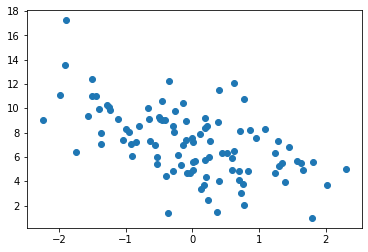

None


In [38]:
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
plotter.show()


In [39]:
func showYHat(yHat: TensorFloat) {
    plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
    plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yHat.makeNumpyArray())
    plotter.show()
}

In [40]:
let linearModel = SequentialModel(layerSizes: [2, 1])
linearModel

▿ SequentialModel
  ▿ sequentialParameter : SequentialParameter
    ▿ parameters : 1 element
      ▿ 0 : DenseLayerV2
        - weightParameter : [[ 0.5442855],
 [0.13326064]]
        - biasParameter : [0.0]
        - gradientChain : (Function)
    - subscribers : 0 elements


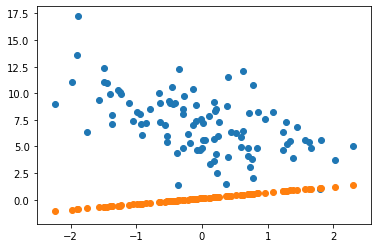

In [41]:
showYHat(yHat: linearModel.apply(inputTensor: A))

In [42]:
//export
public extension Dataset where Element == SupervisedLearningGroup {
    init(featureTensor: TensorFloat, labelTensor: TensorFloat) {
        self.init(elements: SupervisedLearningGroup(features: featureTensor, 
                                     labels: labelTensor))
    }
}

In [43]:
let linearDataSet = Dataset(featureTensor: A, labelTensor: yValidationPoints).batched(100)
let linearDataBunch = DataBunch(trainingDataset: linearDataSet,
                               validationDataset: linearDataSet)

In [44]:
let meanSquaredLossFunction = MeanSquaredErrorLossFunction()
let simpleTrainingDelegate = TrainingDelegate(lossFunction: meanSquaredLossFunction,
                                              predictionExtractor: {$0})
let simpleValidationDelegate = ValidationDelegate(lossFunction: meanSquaredLossFunction, 
                                                  predictionExtractor: {$0})

In [45]:
let linearTeacher = Teacher(dataBunch: linearDataBunch, 
                            trainingDelegate: simpleTrainingDelegate, 
                            validationDelegate: simpleValidationDelegate)

In [46]:
let taughtLinearModel = linearTeacher.teachModel(model: linearModel, 
                                                 numberOfEpochs: 50)

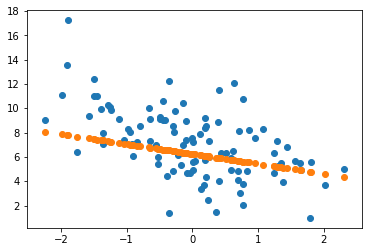

In [47]:
showYHat(yHat: taughtLinearModel.apply(inputTensor: A))

In [48]:
func plotLoss(lossArray: [Float]){
    plotter.figure(figsize: [12, 8])

    let lossAxes = plotter.subplot(2, 1, 2)
    lossAxes.set_ylabel("Loss")
    lossAxes.set_xlabel("Epoch")
    lossAxes.plot(lossArray)

    plotter.show()
}

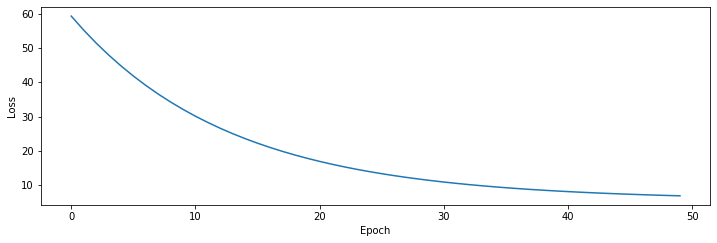

In [49]:
plotLoss(lossArray: simpleTrainingDelegate.lossCount)

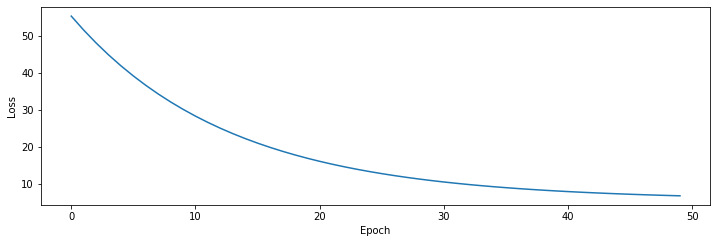

In [50]:
plotLoss(lossArray: simpleValidationDelegate.lossCount)

----

# Activity Data!
----

In [51]:
public func reScaleTensor(tensorToRescale: TensorFloat) -> TensorFloat {
    let maxBoi = TensorFloat([tensorToRescale.max()])
    let minBoi = TensorFloat([tensorToRescale.min()])
    return (tensorToRescale - minBoi) / (maxBoi - minBoi)
}

public func reScaleFeatures(featureTensor: TensorFloat, catVars: Set<Int>, contVars: Set<Int>) -> TensorFloat {
    return TensorFloat(stacking: featureTensor.unstacked(alongAxis: 1).enumerated()
                                               .map { (index, tensi) in 
                                                     if(catVars.contains(index)){
                                                        return reScaleTensor(tensorToRescale: tensi)
                                                     } else if (contVars.contains(index)){
                                                       return normalizeTensor(tensor: tensi) 
                                                     } else {
                                                       return tensi
                                                     }
                                               }, 
                       alongAxis: 1)
}


In [52]:
//export
let carDataYCSV = "./data/activity_labels.csv"
let carDataXCSV = "./data/activities_x_data.csv"

public let numpy = Python.import("numpy")

func createDataSet(featureTensor: TensorFloat, 
                   labelTensor: TensorFloat, 
                   batchSize: Int) -> Dataset<SupervisedLearningGroup> {
    return Dataset(featuresTensor: featureTensor, labelsTensor: labelTensor)
                    .batched(batchSize)
                    .shuffled(sampleCount: 64, 
                              randomSeed: 69, 
                              reshuffleForEachIterator: true)
}

public func getUsedCarDataBunch(validationSize: Double = 0.2,
                             batchSize: Int = 64
                            ) -> DataBunch<SupervisedLearningGroup> {
    let usedCarFeaturesArray = numpy.loadtxt(carDataXCSV, 
                                delimiter: ",", 
                                skiprows: 1, 
                                usecols: Array(1...4), 
                                dtype: Float.numpyScalarTypes.first!)
    let categoricalVariableSet: Set = [0,1,2,3,4,5,6,7]
    let continousVariableSet: Set = [-1]
    let usedCarFeatureTensor = reScaleFeatures(featureTensor: TensorFloat(numpy: usedCarFeaturesArray)!, 
                                               catVars: categoricalVariableSet, 
                                               contVars: continousVariableSet)
    
    let usedCarPrices = numpy.loadtxt(carDataYCSV, 
                                delimiter: ",", 
                                skiprows: 0, 
                                usecols: [1], 
                                dtype: Float.numpyScalarTypes.first!)
    let usedCarLabelsTensor = TensorFloat(numpy: usedCarPrices)!
    
    let numberOfUsedCars = usedCarFeatureTensor.shape[0]
    let numberOfUsedCarFeatures = usedCarFeatureTensor.shape[1]
    
    let validationDatasetSize = Int32(floor(validationSize * Double(numberOfUsedCars)))
    let trainingDataSetSize = Int32(numberOfUsedCars) - validationDatasetSize
    
    
    let splitFeatures = usedCarFeatureTensor
                                .split(sizes: Tensor<Int32>([validationDatasetSize, trainingDataSetSize]), 
                                       alongAxis: 0)
    let splitLabels = usedCarLabelsTensor
                            .split(sizes: Tensor<Int32>([validationDatasetSize, trainingDataSetSize]), 
                                   alongAxis: 0)
    
    let validationDataSet = createDataSet(featureTensor: splitFeatures[0],
                                        labelTensor: splitLabels[0], batchSize: batchSize)
    let trainingDataSet = createDataSet(featureTensor: splitFeatures[1],
                                        labelTensor: splitLabels[1], batchSize: batchSize)
    return DataBunch(trainingDataset: trainingDataSet, 
                     validationDataset: validationDataSet)
}

In [53]:
let usedCarDataBunch = getUsedCarDataBunch()

In [54]:
let numberOfClasses = usedCarDataBunch.trainingDataset.reduce(Int32(0)) {
    (max: Int32, next: SupervisedLearningGroup) -> Int32 in 
    let argMax = Int(next.labels.argmax().scalarized())
    let localMax = Int32(next.labels[argMax].scalarized())
    if(max < localMax) {
        return localMax
    } else {
        return max
    }
}

In [55]:
numberOfClasses

14


# Car Data Test

In [56]:
let meanSquaredErrorLossy = MeanSquaredErrorLossFunction()
let protoTrainingDelegate = TrainingDelegate(lossFunction: meanSquaredErrorLossy, 
                                             predictionExtractor: {pullClassificationsFromPredictions(predictions: $0)})
let protoValidationDelegate = ValidationDelegate(lossFunction: meanSquaredErrorLossy,
                                                 predictionExtractor: {pullClassificationsFromPredictions(predictions: $0)})

In [57]:
let protoModelTeacher = Teacher(dataBunch: usedCarDataBunch, 
                                trainingDelegate: protoTrainingDelegate, 
                                validationDelegate: protoValidationDelegate)

In [58]:
let firstValidationBatch = usedCarDataBunch.validationDataset.first!
let firstTrainingBatch = usedCarDataBunch.trainingDataset.first!

let simpleUntrainedModel = SequentialModel(layerSizes: [
    firstValidationBatch.features.shape[1],
    Int(numberOfClasses)
])
simpleUntrainedModel

▿ SequentialModel
  ▿ sequentialParameter : SequentialParameter
    ▿ parameters : 1 element
      ▿ 0 : DenseLayerV2
        - weightParameter : [[   0.5010717,   0.17530045,   0.34042653,  0.009689325,  -0.11921274,   0.20843786,
    -0.5962774,  -0.18077764,  -0.27737916,   0.48209485,   0.68900084,   -0.8071845,
     -0.575184,   -0.8013398],
 [ 0.027738266,    0.7660936,  -0.14690827,   -0.7095668,  -0.59655887,   0.12082842,
    0.15326382, -0.051222496,   0.45721856,    0.5421977,   0.49318635,    0.2929615,
     0.4794406,  -0.38269788],
 [  0.34159088,   0.39239258,   -0.4031314,   0.56904525,   0.52295595,  -0.53164613,
   -0.52174145,   0.07767709,   -0.6624697,  -0.06902614,   -0.7784723,  -0.36695114,
    0.16288666,  -0.13242827],
 [  -0.6045771,  -0.36411643,   0.53580314,     0.160972,   0.72766155,    0.5706974,
   -0.36569762,   -0.7971248,  0.015426895,  0.027121933,   -0.7967044,     0.528206,
    -0.5097053,    0.4359837]]
        - biasParameter : [0.0, 0.0, 0.0, 

In [59]:
let predictions = simpleUntrainedModel.apply(inputTensor: firstValidationBatch.features)

In [60]:
(predictions[0], predictions[0].argmax())

▿ 2 elements
  - .0 : [-0.25148463,    0.688733, 0.039504953, -0.16842419,   0.3814458,  0.23972909,  -0.5030278,
  -0.6619202, 0.012291545,  0.49559805,  -0.7067602,   0.4778348,  0.14151183, -0.09027644]
  - .1 : 1


In [61]:
(pullClassificationsFromPredictions(predictions: predictions).shape, firstTrainingBatch.labels.shape)

▿ 2 elements
  ▿ .0 : [64, 1]
    ▿ dimensions : 2 elements
      - 0 : 64
      - 1 : 1
  ▿ .1 : [64, 1]
    ▿ dimensions : 2 elements
      - 0 : 64
      - 1 : 1


In [62]:
meanSquaredErrorLossy.calculateLoss(expectedTensor: firstValidationBatch.labels, 
                                    actualTensor: pullClassificationsFromPredictions(predictions: predictions))

24.625


In [63]:
let simpleTrainedModel = withTime { 
    protoModelTeacher.teachModel(model: simpleUntrainedModel, 
                                                      numberOfEpochs: 10)
                                  }

Fatal error: Cannot unbroadcast [64, 1] to [14]: file /swift-base/tensorflow-swift-apis/Sources/TensorFlow/Operators/Basic.swift, line 745
Current stack trace:
0    libswiftCore.so                    0x00007f604e869940 swift_reportError + 50
1    libswiftCore.so                    0x00007f604e8dacf0 _swift_stdlib_reportFatalErrorInFile + 115
2    libswiftCore.so                    0x00007f604e804b48 <unavailable> + 3722056
3    libswiftCore.so                    0x00007f604e804cd7 <unavailable> + 3722455
4    libswiftCore.so                    0x00007f604e5d74e8 <unavailable> + 1438952
5    libswiftCore.so                    0x00007f604e7d85ce <unavailable> + 3540430
6    libswiftCore.so                    0x00007f604e5d6c09 <unavailable> + 1436681


: 

In [ ]:
let predictions = simpleTrainedModel.apply(inputTensor: firstValidationBatch.features)
meanSquaredErrorLossy.calculateLoss(expectedTensor: firstValidationBatch.labels, 
                                    actualTensor: predictions)

In [ ]:
let predictions = simpleTrainedModel.apply(inputTensor: firstTrainingBatch.features)
meanSquaredErrorLossy.calculateLoss(expectedTensor: firstTrainingBatch.labels, 
                                    actualTensor: predictions)

In [ ]:
usedCarDataBunch.trainingDataset.reduce(simpleTrainedModel){
    let predictions = $0.apply(inputTensor: $1.features)
    let lossBoi = meanSquaredErrorLossy.calculateLoss(expectedTensor: $1.labels, 
                                    actualTensor: predictions)
    print(lossBoi)
    return $0
}

In [ ]:
plotLoss(lossArray: protoTrainingDelegate.lossCount)

In [ ]:
plotLoss(lossArray: protoValidationDelegate.lossCount)

# Tensor Flow Stuff

In [137]:
let inputSize = Int(firstValidationBatch.features.shape[1])
let hiddenSize = Int(numberOfClasses + 1)


struct UsedCarModel: Layer {
    var layer1 = Dense<Float>(inputSize: inputSize, outputSize: hiddenSize / 2, activation: relu)
    var layer2 = Dense<Float>(inputSize: hiddenSize / 2, outputSize: hiddenSize)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: layer1, layer2)
    }
}

In [138]:
var model = UsedCarModel()

In [139]:
let firstTrainPredictions = model(firstValidationBatch.features)
firstTrainPredictions[0..<5]

[[  -0.16867733,    -0.3908889,   -0.11589784,   -0.33115885,   0.019876909,   -0.32318652,
   0.0008447634,   -0.19173919,   0.082386255,   -0.49828553,      0.512353,   -0.24782668,
      0.4339627,   0.066994555,   -0.27064428],
 [  -0.16944711,   -0.39100063,  -0.117502525,   -0.33510682,   0.021741083,    -0.3247286,
  -0.0007767936,   -0.19178829,    0.08300799,   -0.50409687,    0.51666963,   -0.24440321,
      0.4364759,    0.06820183,   -0.27316266],
 [  -0.17104454,   -0.39210567,   -0.11863805,   -0.33736306,   0.023826974,   -0.32485175,
   -0.001420216,   -0.19083972,    0.08203415,    -0.5084576,    0.52030057,     -0.242687,
     0.43761852,    0.06811581,   -0.27490062],
 [   -0.1734835,   -0.39422065,   -0.11929659,    -0.3378994,    0.02613829,    -0.3235323,
  -0.0010691349,    -0.1888769,   0.079438016,    -0.5113435,    0.52323425,   -0.24270666,
     0.43736774,    0.06671485,   -0.27584514],
 [   -0.1759225,    -0.3963357,   -0.11995514,   -0.33843574,    0.02844

In [140]:
func logSumExp<Scalar>(_ x: Tensor<Scalar>) -> Tensor<Scalar> where Scalar:TensorFlowFloatingPoint{
    let m = x.max(alongAxes: -1)
    return m + log(exp(x-m).sum(alongAxes: -1))
}

In [141]:
func logSoftmax<Scalar>(_ activations: Tensor<Scalar>) -> Tensor<Scalar> where Scalar:TensorFlowFloatingPoint{
    return activations - logSumExp(activations)
}

In [142]:
func nll<Scalar>(_ input: Tensor<Scalar>, _ target :Tensor<Int32>) -> Tensor<Scalar> 
    where Scalar:TensorFlowFloatingPoint{
        let idx: Tensor<Int32> = Raw.range(start: Tensor(0), limit: Tensor(numericCast(target.shape[0])), delta: Tensor(1))
        let indices = Raw.concat(concatDim: Tensor(1), [idx.expandingShape(at: 1), target.expandingShape(at: 1)])
        let losses = Raw.gatherNd(params: input, indices: indices)
        return -losses.mean()
    }

In [143]:
let smPred = logSoftmax(firstTrainPredictions)

In [144]:
nll(smPred, Tensor<Int32>(firstTrainingBatch.labels.squeezingShape(at: 1)))

2.174168


In [145]:
print(type(of: firstTrainPredictions))
print(type(of: firstValidationBatch.labels))

Tensor<Float>
Tensor<Float>


In [146]:
let loss = softmaxCrossEntropy(logits: firstTrainPredictions, 
                               labels: Tensor<Int32>(firstTrainingBatch.labels.squeezingShape(at: 1)))
loss

2.1741683


In [147]:
timeTrials(trials: 100) { 
_ = nll(smPred, Tensor<Int32>(firstTrainingBatch.labels.squeezingShape(at: 1)))
}

average: 78.7725 µs,   min: 76.394 µs,   max: 109.56 µs


In [148]:
timeTrials(trials: 100) { 
_ = softmaxCrossEntropy(logits: firstTrainPredictions, 
                               labels: Tensor<Int32>(firstTrainingBatch.labels.squeezingShape(at: 1)))
}

average: 54.53172 µs,   min: 52.69 µs,   max: 82.11 µs


In [149]:
public func accuracy(_ output: TensorFloat, _ target: Tensor<Int32>) -> TensorFloat {
    let corrects = TensorFloat(output.argmax(squeezingAxis: 1) .== target)
    return corrects.mean()
}

In [150]:
accuracy(firstTrainPredictions, Tensor<Int32>(firstTrainingBatch.labels.squeezingShape(at: 1)))

1.0


In [151]:
let optimizer = SGD(for: model, learningRate: 1e-2)

In [152]:
let (libLoss2, libGrads) = model.valueWithGradient {
    model -> TensorFloat in
    let libPreds = model(firstValidationBatch.features)
    return softmaxCrossEntropy(logits: libPreds, 
                               labels: Tensor<Int32>(firstValidationBatch.labels.squeezingShape(at: 1)))
}
libLoss2

2.9348953


In [153]:
optimizer.update(&model.allDifferentiableVariables, along: libGrads)

In [154]:
model(firstTrainingBatch.features).argmax(squeezingAxis: 1)

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


In [155]:
accuracy(model(firstTrainingBatch.features), Tensor<Int32>(firstTrainingBatch.labels.squeezingShape(at: 1)))

0.0


In [156]:
let epochCount = 100
var trainingLoss: [Float] = []


In [157]:

var model3 = UsedCarModel()

In [158]:
let optimizer = SGD(for: model3, learningRate: 1e-2)

In [159]:
withTime { 
    for epoch in 1...100 {
        var epochLoss: Float = 0
        var epochAccuracy: Float = 0
        var batchCount: Int = 0

        for dataGroup in usedCarDataBunch.trainingDataset {
            let (loss, libraryGradients) = model3.valueWithGradient {
                model -> TensorFloat in
                let libPreds = model(dataGroup.features)
                return softmaxCrossEntropy(logits: libPreds, 
                               labels: Tensor<Int32>(dataGroup.labels.squeezingShape(at: 1)))
            }

            optimizer.update(&model3.self, along: libraryGradients)

            let preds = model(dataGroup.features)
            let batchAccuracy = accuracy(preds, Tensor<Int32>(dataGroup.labels.squeezingShape(at: 1))).scalarized()
            let batchLoss = loss.scalarized()
            epochAccuracy += batchAccuracy
            epochLoss += batchLoss

            batchCount += 1
        }
        trainingLoss.append(epochLoss / Float(batchCount))
    }
}

elapsed time: 20.850573168 s


In [ ]:
14.845449664 / 12.98729881

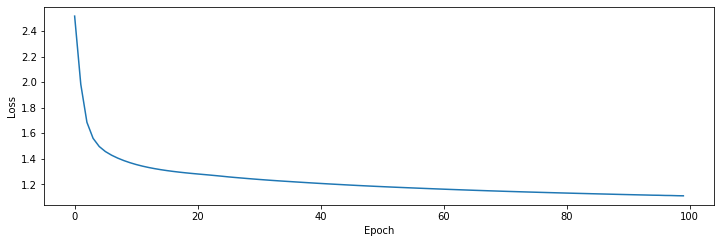

In [160]:
plotLoss(lossArray: trainingLoss)

In [167]:
let firstValidationBatch = usedCarDataBunch.validationDataset.first!

usedCarDataBunch.validationDataset.reduce(model3){
    model, dataBatch in
        print(model(dataBatch.features).argmax(squeezingAxis: 1))
print(dataBatch.labels.squeezingShape(at: 1))
    
    return model
}

print("Pred \(model3(firstValidationBatch.features).argmax(squeezingAxis: 1))")
print("Actual" + firstValidationBatch.labels.squeezingShape(at: 1))
print(accuracy(model3(firstValidationBatch.features), 
               Tensor<Int32>(firstValidationBatch.labels.squeezingShape(at: 1))))

: 

# Tensorflow simple

In [ ]:
struct SimpleModelTF: Layer {
    var layer1 = Dense<Float>(inputSize: 2, outputSize: 1)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return layer1(input)
    }
}

In [ ]:
var tfSimpleModel = SimpleModelTF()

In [ ]:
let optimizerTF = SGD(for: tfSimpleModel, learningRate: 1e-2)

In [ ]:
showYHat(yHat: tfSimpleModel(A))

In [ ]:
var simpleTrainingAccuracy: [Float] = []
var simpleTrainingLoss: [Float] = []

In [ ]:
for epoch in 1...50 {
    var epochLoss: Float = 0
    var epochAccuracy: Float = 0
    var batchCount: Int = 0
    
    for dataGroup in linearDataBunch.trainingDataset {
        let (loss, libraryGradients) = tfSimpleModel.valueWithGradient {
            model -> TensorFloat in
            let libPreds = model(dataGroup.features)            
            return  meanSquaredError(predicted: libPreds, expected: dataGroup.labels)
        }
        
        optimizerTF.update(&tfSimpleModel.allDifferentiableVariables, along: libraryGradients)
        
        let preds = tfSimpleModel(dataGroup.features)
        let batchAccuracy = accuracy(expected: dataGroup.labels, 
                                  actual: preds)
        let batchLoss = loss.scalarized()
        
        simpleTrainingAccuracy.append(batchAccuracy)
        simpleTrainingLoss.append(batchLoss)
    }
}

In [ ]:
plotLoss(lossArray: simpleTrainingLoss)

In [ ]:
showYHat(yHat: tfSimpleModel(A))